# Machine failure PyTorch model

Adapted from the [SageMaker script mode](https://github.com/aws/amazon-sagemaker-examples/tree/master/sagemaker-script-mode) example.

## Imports

In [1]:
import sagemaker
import subprocess
import sys
import random
import math
import pandas as pd
import os
import boto3
import numpy as np
from sklearn.model_selection import train_test_split
from sagemaker.pytorch import PyTorch
from sagemaker.serializers import NumpySerializer, JSONSerializer, CSVSerializer
from sagemaker.deserializers import NumpyDeserializer, JSONDeserializer
from sagemaker.predictor import Predictor

Make sure your SageMaker version is updated.

In [2]:
# SageMaker Python SDK version 2.x is required
original_version = sagemaker.__version__
if sagemaker.__version__ != "2.24.1":
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sagemaker==2.24.1"])
    import importlib

    importlib.reload(sagemaker)

## Parameters

In [4]:
random.seed(42)

# Useful SageMaker variables
try:
    # You're using a SageMaker notebook
    sess = sagemaker.Session()
    bucket = sess.default_bucket()
    role = sagemaker.get_execution_role()
except ValueError:
    # You're using a notebook somewhere else
    print("Setting role and SageMaker session manually...")
    bucket = "marcus-ml-demo"
    region = "us-east-1"

    iam = boto3.client("iam")
    sagemaker_client = boto3.client("sagemaker")

    sagemaker_execution_role_name = (
        "AmazonSageMaker-ExecutionRole-20200630T141851"  # Change this to your role name
    )
    role = iam.get_role(RoleName=sagemaker_execution_role_name)["Role"]["Arn"]
    boto3.setup_default_session(region_name=region, profile_name="default")
    sess = sagemaker.Session(sagemaker_client=sagemaker_client, default_bucket=bucket)

# Local data paths
train_dir = os.path.join(os.getcwd(), "data/train")
test_dir = os.path.join(os.getcwd(), "data/test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Data paths in S3
s3_prefix = "marcus-machine-failure"
csv_s3_prefix = f"{s3_prefix}/csv"
csv_s3_uri = f"s3://{bucket}/{s3_prefix}/csv"
numpy_train_s3_prefix = f"{s3_prefix}/numpy/train"
numpy_train_s3_uri = f"s3://{bucket}/{numpy_train_s3_prefix}"
numpy_test_s3_prefix = f"{s3_prefix}/numpy/test"
numpy_test_s3_uri = f"s3://{bucket}/{numpy_test_s3_prefix}"
csv_train_s3_uri = f"{csv_s3_uri}/train"
csv_test_s3_uri = f"{csv_s3_uri}/test"

# Enable Local Mode training
enable_local_mode_training = False

# Endpoint names
pytorch_endpoint_name = "pytorch-endpoint"

## Load training data

In [30]:
import s3fs

s3 = s3fs.S3FileSystem(anon=False)

key = "ai4i2020_prep.csv"
with s3.open(f'{bucket}/{s3_prefix}/{key}','r') as f:
    feature_df = pd.read_csv(f)

In [31]:
#feature_df['y'] = feature_df['y'].astype(float)
feature_df['high'] = feature_df['high'].astype(float)
feature_df['low'] = feature_df['low'].astype(float)
feature_df['medium'] = feature_df['medium'].astype(float)
feature_df.tail()

,y,air_temperature,process_temperature,rotational_speed,torque,tool_wear,high,low,medium
19317,1,0.565180,0.518519,0.132712,0.578316,0.830040,1.0,0.0,0.0
19318,1,0.338743,0.356003,0.878347,0.094848,0.335968,0.0,0.0,1.0
19319,1,0.462273,0.655407,0.319558,0.330801,0.873518,0.0,0.0,0.0
19320,1,0.647715,0.594625,0.302678,0.366137,0.893281,0.0,0.0,1.0
19321,1,0.730462,0.598804,0.116997,0.590625,0.280632,0.0,0.0,1.0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(feature_df.iloc[:, 1:], feature_df['y'], test_size=0.33, random_state=42)

In [33]:
# Save as Numpy
np.save(os.path.join(train_dir, "x_train.npy"), X_train.values)
np.save(os.path.join(test_dir, "x_test.npy"), X_test.values)
np.save(os.path.join(train_dir, "y_train.npy"), y_train.values)
np.save(os.path.join(test_dir, "y_test.npy"), y_test.values)

In [34]:

s3_resource_bucket = boto3.Session().resource("s3").Bucket(bucket)

s3_resource_bucket.Object(os.path.join(numpy_train_s3_prefix, "x_train.npy")).upload_file(
    "data/train/x_train.npy"
)
s3_resource_bucket.Object(os.path.join(numpy_train_s3_prefix, "y_train.npy")).upload_file(
    "data/train/y_train.npy"
)
s3_resource_bucket.Object(os.path.join(numpy_test_s3_prefix, "x_test.npy")).upload_file(
    "data/test/x_test.npy"
)
s3_resource_bucket.Object(os.path.join(numpy_test_s3_prefix, "y_test.npy")).upload_file(
    "data/test/y_test.npy"
)

## PyTorch

In [37]:
hyperparameters = {"epochs": 25, "batch_size": 128, "learning_rate": 0.01}

if enable_local_mode_training:
    train_instance_type = "local"
    inputs = {"train": f"file://{train_dir}", "test": f"file://{test_dir}"}
else:
    train_instance_type = "ml.c5.xlarge"
    inputs = {"train": numpy_train_s3_uri, "test": numpy_test_s3_uri}

estimator_parameters = {
    "entry_point": "train_deploy_pytorch_without_dependencies.py",
    "source_dir": "pytorch_script",
    "instance_type": train_instance_type,
    "instance_count": 1,
    "hyperparameters": hyperparameters,
    "role": role,
    "base_job_name": "pytorch-model",
    "framework_version": "1.5",
    "py_version": "py3",
}

estimator = PyTorch(**estimator_parameters)
estimator.fit(inputs)

2021-07-19 20:24:38 Starting - Starting the training job...
2021-07-19 20:24:40 Starting - Launching requested ML instancesProfilerReport-1626726278: InProgress
......
2021-07-19 20:26:02 Starting - Preparing the instances for training.........
2021-07-19 20:27:22 Downloading - Downloading input data...
2021-07-19 20:28:02 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-19 20:28:01,602 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-07-19 20:28:01,604 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-07-19 20:28:01,613 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-19 20:28:01,622 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-19 20:28:17,199 sagemaker-training-toolkit INFO     

Again, after the estimator finishes training, we can deploy it to a SageMaker endpoint.

In [38]:
existing_endpoints = sess.sagemaker_client.list_endpoints(
    NameContains=pytorch_endpoint_name, MaxResults=30
)["Endpoints"]
if not existing_endpoints:
    pytorch_predictor = estimator.deploy(
        initial_instance_count=1, instance_type="ml.m5.xlarge", endpoint_name=pytorch_endpoint_name
    )
else:
    pytorch_predictor = Predictor(
        endpoint_name="pytorch-endpoint",
        sagemaker_session=sess,
        serializer=JSONSerializer(),
        deserializer=JSONDeserializer(),
    )

---------------!

Then we can use the endpoint to make predictions.

In [53]:
pytorch_predictor.serializer = JSONSerializer()
pytorch_predictor.deserializer = JSONDeserializer()

y_preds = [pytorch_predictor.predict(xt) for xt in X_test.values]

In [58]:
y_preds = np.array(y_preds)
test_pred_class = (y_preds > 0.5) + 0

In [62]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, test_pred_class, normalize=True)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.82


In [64]:
from sklearn.metrics import precision_recall_fscore_support
(precision, recall, fbeta, support) = precision_recall_fscore_support(y_test, test_pred_class, average='micro')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F-Beta: {fbeta:.2f}')
print(f'Support: {support}')

Precision: 0.82
Recall: 0.82
F-Beta: 0.82
Support: None


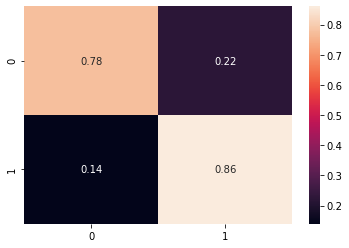

In [70]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import seaborn as sns

_ = sns.heatmap(confusion_matrix(y_test, test_pred_class, normalize='true'), annot=True)

## Cleanup

In [71]:
resources = (
    [pytorch_endpoint_name, pytorch_predictor],
)

for resource in resources:
    existing_endpoints = sess.sagemaker_client.list_endpoints(
        NameContains=resource[0], MaxResults=30
    )["Endpoints"]
    if existing_endpoints:
        resource[1].delete_endpoint(delete_endpoint_config=True)